In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
import time
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf
import os
import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, auc, f1_score, roc_curve, RocCurveDisplay
from preprocessing import preprocess_data

In [2]:
x_train, x_test, y_train, y_test = preprocess_data(path='plt')

Loading data


100%|██████████| 21799/21799 [03:48<00:00, 95.33it/s] 


Dropping other
(array([0, 1]), array([9069, 5469], dtype=int64))
Filtering outliers


100%|██████████| 14538/14538 [00:19<00:00, 761.03it/s]


(array([0, 1]), array([9069, 5469], dtype=int64))
(array([0, 1]), array([9069, 5469], dtype=int64))
(array([0, 1]), array([8769, 5023], dtype=int64))
Applying moving average


100%|██████████| 13792/13792 [01:53<00:00, 121.17it/s]


Balancing data
(array([0, 1]), array([8769, 5023], dtype=int64))
Train-test split


### Обучение модели

Архитектура сети

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=12, 
            out_channels=48,
            kernel_size=7,
            stride=2
        )
        self.conv2 = nn.Conv1d(
            in_channels=48,
            out_channels=144,
            kernel_size=5,
            stride=2,
        )
        self.conv3 = nn.Conv1d(
            in_channels=144,
            out_channels=288,
            kernel_size=5,
            stride=2
        )
        self.fc1 = nn.Linear(in_features=4032, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
        #return self.seq(x)


Обучение сети

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = Model().to(device)
print(net)

cpu
Model(
  (conv1): Conv1d(12, 48, kernel_size=(7,), stride=(2,))
  (conv2): Conv1d(48, 144, kernel_size=(5,), stride=(2,))
  (conv3): Conv1d(144, 288, kernel_size=(5,), stride=(2,))
  (fc1): Linear(in_features=4032, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
)


In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

def test(net, samples):
    with torch.no_grad():
        return net.forward(torch.Tensor(samples))

def train(net, samples, labels, epochs, batch_size):
    samples = torch.Tensor(samples)
    labels = torch.Tensor(np.array([labels]).T)
    dataset = TensorDataset(samples, labels)
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    start_time = time.time()
    test_accuracy_list = [0]

    for epoch in range(epochs):
        loss_value = 0.0
        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_value += loss.item()
        train_accuracy = accuracy_score(
            y_train,#.to(device, non_blocking=True), 
            [(1 if pred[0] > 0.5 else 0) for pred in test(net, torch.Tensor(x_train).to(device, non_blocking=True))]
        )
        test_accuracy = accuracy_score(
            y_test,#.to(device, non_blocking=True), 
            [(1 if pred[0] > 0.5 else 0) for pred in test(net, torch.Tensor(x_test).to(device, non_blocking=True))]
        )
        test_accuracy_list.append(test_accuracy)
        print(f'Epoch {epoch:5} loss = {loss_value:.4f} Train: {train_accuracy:.4f} Test {test_accuracy:.4f}')
        if epoch > 5 and np.average(test_accuracy_list[-4:]) < test_accuracy_list[-5]:
            print('Test accuracy decreasing, break')
            break

In [6]:
train(net, x_train, y_train, 30, 128)

Epoch     0 loss = 34.8289 Train: 0.7668 Test 0.7611
Epoch     1 loss = 22.9923 Train: 0.8441 Test 0.8447
Epoch     2 loss = 18.9119 Train: 0.8495 Test 0.8510
Epoch     3 loss = 17.6766 Train: 0.8805 Test 0.8696
Epoch     4 loss = 16.0982 Train: 0.8878 Test 0.8723
Epoch     5 loss = 15.9996 Train: 0.8840 Test 0.8670
Epoch     6 loss = 15.2304 Train: 0.8595 Test 0.8470
Epoch     7 loss = 14.9443 Train: 0.8952 Test 0.8825
Test accuracy decreasing, break


Accuracy

In [7]:
print(f'Train accuracy: {accuracy_score(y_train, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_train)])}')
print(f'Test accuracy: {accuracy_score(y_test, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_test)])}')

Train accuracy: 0.895193401592719
Test accuracy: 0.8825481088254811


ROC-AUC

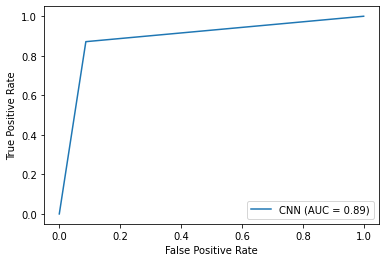

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, [(1 if pred[0] > 0.5 else 0) for pred in test(net, x_test)])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CNN')
display.plot()
plt.show()

In [66]:
class ConvNet(nn.Module):
    def __init__(
        self,
        fc_layers_size,
        conv_layers
    ) -> None:
        super(ConvNet, self).__init__()
        layers = []
        in_channels = 12
        conv_out_size = 1000
        for kernel_size, out_channels, stride in conv_layers:
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride),
                nn.ReLU(),
                nn.MaxPool1d(2, 2)
            ]
            in_channels = out_channels
            # for Conv1d
            conv_out_size = self.conv_eval(conv_out_size, kernel_size, stride, 1)
            # for MaxPool1d
            conv_out_size = self.conv_eval(conv_out_size, 2, 2, 1)
        layers.append(nn.Flatten())
        features_in = conv_out_size * out_channels
        for fc_out in fc_layers_size[:-1]:
            layers += [
                nn.Linear(features_in, fc_out),
                nn.ReLU()
            ]
            features_in = fc_out
        layers += [
            nn.Linear(features_in, fc_layers_size[-1]),
            nn.Sigmoid()
        ]
        self.seq = nn.Sequential(*layers)
    
    @classmethod
    def conv_eval(self, len_in, kernel_size, stride, dilation):
        return int((len_in - 1 - dilation * (kernel_size - 1)) / stride + 1)
    
    def forward(self, x):
        return self.seq(x)
    
    def train_net(
        self,
        criterion,
        optimizer,
        objects,
        labels,
        epochs,
        batch_size
    ):
        objects = torch.Tensor(objects)
        labels = torch.Tensor(np.array([labels]).T)
        dataset = TensorDataset(objects, labels)
        dataloader = DataLoader(dataset, batch_size, shuffle=True)
        test_accuracy_list = [0]

        for epoch in range(epochs):
            loss_value = 0.0
            for i, batch in enumerate(dataloader):
                inputs, labels = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_value += loss.item()
            train_accuracy = accuracy_score(
                y_train,#.to(device, non_blocking=True), 
                [(1 if pred[0] > 0.5 else 0) for pred in test(self, torch.Tensor(x_train).to(device, non_blocking=True))]
            )
            test_accuracy = accuracy_score(
                y_test,#.to(device, non_blocking=True), 
                [(1 if pred[0] > 0.5 else 0) for pred in test(self, torch.Tensor(x_test).to(device, non_blocking=True))]
            )
            test_accuracy_list.append(test_accuracy)
            print(f'Epoch {epoch:5} loss = {loss_value:.4f} Train: {train_accuracy:.4f} Test {test_accuracy:.4f}')
            if epoch > 5 and np.average(test_accuracy_list[-4:]) < test_accuracy_list[-5]:
                print('Test accuracy decreasing, break')
                break
    
    def test(self, samples):
        with torch.no_grad():
            return self.forward(torch.Tensor(samples))

In [67]:
generated = ConvNet(
    fc_layers_size=[500, 1],
    conv_layers=[
        (7, 48, 2),
        (5, 144, 2),
        (5, 288, 2),
    ]
)
generated
generated.to(device)
generated.train_net(
    nn.BCELoss(), 
    optim.Adam(generated.parameters(), lr=0.0001),
    x_train, 
    y_train, 
    30, 
    128
)

Epoch     0 loss = 35.4064 Train: 0.7558 Test 0.7664
Epoch     1 loss = 23.9236 Train: 0.8383 Test 0.8457
Epoch     2 loss = 19.7527 Train: 0.8611 Test 0.8610
Epoch     3 loss = 17.8433 Train: 0.8695 Test 0.8716
Epoch     4 loss = 16.7468 Train: 0.8798 Test 0.8802
Epoch     5 loss = 16.7247 Train: 0.8798 Test 0.8812
Epoch     6 loss = 15.5908 Train: 0.8852 Test 0.8825
Epoch     7 loss = 15.3138 Train: 0.8864 Test 0.8872
Epoch     8 loss = 14.7874 Train: 0.8951 Test 0.8898
Epoch     9 loss = 15.5108 Train: 0.8844 Test 0.8845
Epoch    10 loss = 14.3698 Train: 0.8906 Test 0.8925
Epoch    11 loss = 14.3571 Train: 0.8997 Test 0.8925
Epoch    12 loss = 13.9639 Train: 0.8987 Test 0.8895
Test accuracy decreasing, break
